**MSCI USA Momentum strategy implementation using Python for the Indian stock market**

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  10 of 10 completed


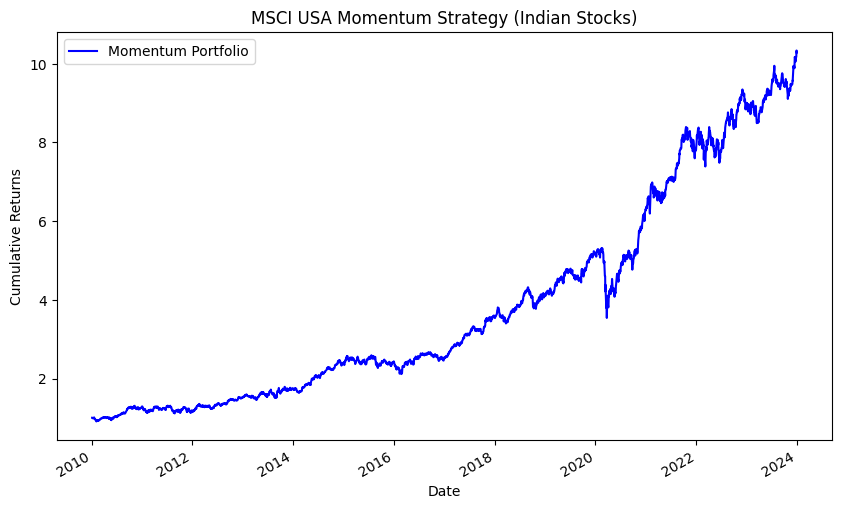

Total Return: 928.71%
Annualized Return: 18.12%


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_nifty50_tickers():
    # Fetch the current constituents of Nifty 50 from a reliable source
    nifty50_tickers = [
        'RELIANCE.NS', 'HDFCBANK.NS', 'INFY.NS', 'TCS.NS', 'HINDUNILVR.NS',
        'ICICIBANK.NS', 'KOTAKBANK.NS', 'ITC.NS', 'SBIN.NS', 'BHARTIARTL.NS'
    ]
    return nifty50_tickers

def calculate_momentum_scores(stocks, start_date, end_date):
    momentum_scores = []

    for stock in stocks:
        # Download historical stock prices
        data = yf.download(stock, start=start_date, end=end_date)['Adj Close']

        # Get market capitalization (adjusted close * outstanding shares)
        market_cap = yf.Ticker(stock).info['marketCap']

        # Calculate 12-month and 6-month returns excluding recent 1-month
        returns_12m = data.pct_change(13).iloc[-1]  # 12-month returns
        returns_6m = (data[-1] / data[-7]) - 1  # 6-month returns

        # Calculate annualized standard deviation of weekly returns over 3 years
        weekly_returns = data.pct_change().dropna()
        annualized_std_dev = weekly_returns.std() * np.sqrt(52)  # Annualized standard deviation

        # Calculate risk-adjusted price momentum for 12-month horizon
        if pd.notna(returns_12m):
            risk_adjusted_momentum_12m = returns_12m / annualized_std_dev
        else:
            risk_adjusted_momentum_12m = np.nan

        # Calculate risk-adjusted price momentum for 6-month horizon
        if pd.notna(returns_6m):
            risk_adjusted_momentum_6m = returns_6m / annualized_std_dev
        else:
            risk_adjusted_momentum_6m = np.nan

        # Combine 12-month and 6-month risk-adjusted momentums into a single score
        if pd.notna(risk_adjusted_momentum_12m) and pd.notna(risk_adjusted_momentum_6m):
            momentum_z_score = 0.5 * risk_adjusted_momentum_12m + 0.5 * risk_adjusted_momentum_6m
        elif pd.notna(risk_adjusted_momentum_12m):
            momentum_z_score = risk_adjusted_momentum_12m
        elif pd.notna(risk_adjusted_momentum_6m):
            momentum_z_score = risk_adjusted_momentum_6m
        else:
            momentum_z_score = np.nan

        # Compute Momentum Score from Momentum Z-Score
        if pd.notna(momentum_z_score):
            if momentum_z_score > 0:
                momentum_score = 1 + momentum_z_score
            elif momentum_z_score < 0:
                momentum_score = 1 / (1 - momentum_z_score)
            else:
                momentum_score = np.nan
        else:
            momentum_score = np.nan

        # Calculate Momentum Weight = Momentum Score * Market Capitalization Weight
        if pd.notna(market_cap) and pd.notna(momentum_score):
            momentum_weight = momentum_score * (market_cap / 1e9)  # Market cap in billions (for weight)
        else:
            momentum_weight = np.nan

        momentum_scores.append(momentum_weight)

    # Normalize Momentum Weights to 100%
    momentum_scores = np.array(momentum_scores)
    normalized_momentum_weights = (momentum_scores / np.sum(momentum_scores)) * 100

    return pd.Series(normalized_momentum_weights, index=stocks, name='Momentum Weight')

def select_top_momentum_stocks(momentum_weights, num_stocks):
    top_momentum_stocks = momentum_weights.nlargest(num_stocks).index.tolist()
    return top_momentum_stocks

def backtest_momentum_strategy(top_momentum_stocks, start_date, end_date):
    # Download historical prices for selected top momentum stocks
    portfolio_data = yf.download(top_momentum_stocks, start=start_date, end=end_date)['Adj Close']

    # Calculate portfolio returns
    portfolio_returns = portfolio_data.pct_change().dot(np.ones(len(top_momentum_stocks)) / len(top_momentum_stocks))

    # Calculate cumulative returns
    cumulative_returns = (portfolio_returns + 1).cumprod()

    # Plot cumulative returns
    plt.figure(figsize=(10, 6))
    cumulative_returns.plot(label='Momentum Portfolio', color='blue')
    plt.title('MSCI USA Momentum Strategy (Indian Stocks)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

    # Calculate performance metrics
    total_return = cumulative_returns[-1] - 1
    annualized_return = (cumulative_returns[-1])**(1 / (cumulative_returns.index[-1].year - cumulative_returns.index[0].year + 1)) - 1

    print(f"Total Return: {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")

if __name__ == "__main__":
    # Specify parameters
    start_date = '2010-01-01'
    end_date = '2023-12-31'
    num_top_stocks = 10

    # Step 1: Get the Nifty 50 tickers
    nifty50_stocks = get_nifty50_tickers()

    # Step 2: Calculate momentum weights (normalized to 100%) for the Nifty 50 stocks
    momentum_weights = calculate_momentum_scores(nifty50_stocks, start_date, end_date)

    # Step 3: Select top momentum stocks based on Momentum Weight
    top_momentum_stocks = select_top_momentum_stocks(momentum_weights, num_top_stocks)

    # Step 4: Backtest momentum strategy with selected top momentum stocks
    backtest_momentum_strategy(top_momentum_stocks, start_date, end_date)


**Maintaining the Index**

In [ ]:
import yfinance as yf
import numpy as np
from scipy.stats import percentileofscore

def compute_annualized_volatility(index_ticker, end_date):
    # Fetch historical data for the index
    index_data = yf.download(index_ticker, end=end_date, period='3mo')['Adj Close']

    # Calculate daily returns over the trailing 3 months
    daily_returns = index_data.pct_change()

    # Compute annualized volatility (trailing 3-month period)
    annualized_volatility = np.sqrt(250) * daily_returns.std()

    return annualized_volatility[-1]

def compute_monthly_volatility_change(annualized_volatility, prev_annualized_volatility):
    # Compute monthly change in volatility (delta)
    monthly_volatility_change = annualized_volatility / prev_annualized_volatility - 1

    return monthly_volatility_change

def trigger_adhoc_rebalancing(index_ticker, end_date, threshold):
    # Compute annualized volatility at T-9 date (previous month-end)
    prev_annualized_volatility = compute_annualized_volatility(index_ticker, end_date)

    # Compute annualized volatility at T-9-1 date (2 months prior)
    prev_prev_annualized_volatility = compute_annualized_volatility(index_ticker, end_date - pd.DateOffset(months=1))

    # Compute monthly change in volatility (delta)
    monthly_volatility_change = compute_monthly_volatility_change(prev_annualized_volatility, prev_prev_annualized_volatility)

    # Calculate the threshold (95th percentile of monthly changes in volatility)
    threshold = np.percentile(monthly_volatility_change, 95)

    # Check if ad-hoc rebalancing is triggered based on the threshold
    if monthly_volatility_change > threshold:
        return True
    else:
        return False

# Example Usage:
index_ticker = '^GSPC'  # S&P 500 Index (Reference Index)
end_date = '2024-04-30'  # Current date
threshold = 0.05  # Example threshold value

# Trigger ad-hoc rebalancing based on volatility criteria
is_rebalancing_triggered = trigger_adhoc_rebalancing(index_ticker, end_date, threshold)

if is_rebalancing_triggered:
    print("Ad-hoc rebalancing triggered!")
else:
    print("Ad-hoc rebalancing not triggered.")